Salman_NUS Graded Assignment 5.1: Transformer-based Sentiment Classification.ipynb

Task 1: Load and Inspect the IMDB Dataset

In [3]:
# Task 1: Import Libraries and Load IMDB Dataset (Keras version)

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load IMDB dataset with top 10,000 most frequent words
num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))
print("Example review (token IDs):", X_train[0])
print("Example label:", y_train[0])


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 25000
Test samples: 25000
Example review (token IDs): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 

Task 2: Data Processing and Exploration

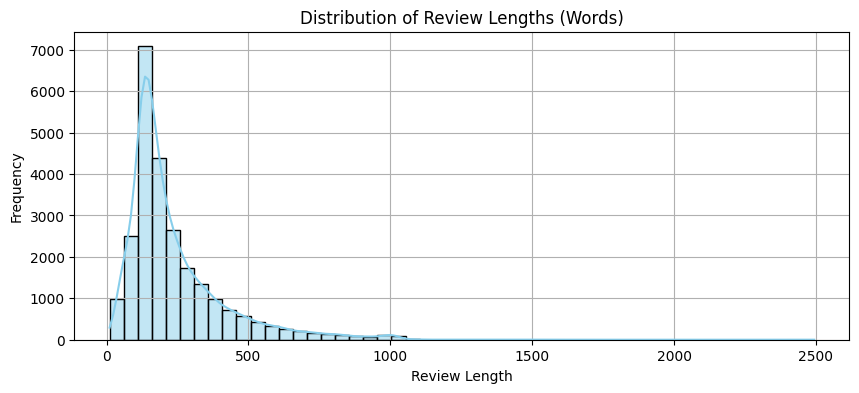

<ipython-input-4-e72a44135179>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_labels, x='label', palette='Set2')


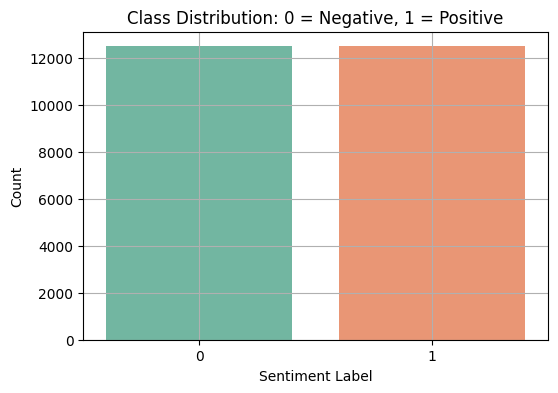

Are there missing values?
X_train: False
y_train: False
X_train_padded shape: (25000, 256)
X_test_padded shape: (25000, 256)


In [4]:
# Calculate review lengths
review_lengths = [len(x) for x in X_train]

# Plot distribution
plt.figure(figsize=(10, 4))
sns.histplot(review_lengths, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Review Lengths (Words)')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Convert labels to DataFrame for easy plotting
df_labels = pd.DataFrame({'label': y_train})
plt.figure(figsize=(6, 4))
sns.countplot(data=df_labels, x='label', palette='Set2')
plt.title('Class Distribution: 0 = Negative, 1 = Positive')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.grid(True)
plt.show()


# Check for any missing entries
print("Are there missing values?")
print("X_train:", any([x is None for x in X_train]))
print("y_train:", pd.isnull(y_train).any())

# Choose maximum review length (truncate or pad to this length)
maxlen = 256

# Pad sequences
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')

print("X_train_padded shape:", X_train_padded.shape)
print("X_test_padded shape:", X_test_padded.shape)



Task 3: Construct a Basic Transformer Model

In [6]:
from tensorflow.keras import layers, models

# Transformer encoder block
def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    # Multi-head attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward network
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    x = layers.Dropout(dropout)(ffn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn)

    return x

    # Inputs
input_layer = layers.Input(shape=(256,))

# Embedding
embedding_layer = layers.Embedding(input_dim=10000, output_dim=64)(input_layer)

# Transformer Encoder Block
x = transformer_encoder(embedding_layer)

# Pooling and Output
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

# Build the model
basic_transformer_model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile
basic_transformer_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Summary
basic_transformer_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 256, 64)   │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │     33,216 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 64)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 64)   │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 64)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 690,113 (2.63 MB)

 Trainable params: 690,113 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

Task 5: Train the basic model

In [7]:
# Task 5: Train the Basic Transformer Model

history_basic = basic_transformer_model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 202s 630ms/step - accuracy: 0.6673 - loss: 0.6091 - val_accuracy: 0.8712 - val_loss: 0.3097
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 195s 608ms/step - accuracy: 0.9097 - loss: 0.2356 - val_accuracy: 0.8810 - val_loss: 0.2995
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 196s 590ms/step - accuracy: 0.9404 - loss: 0.1555 - val_accuracy: 0.8812 - val_loss: 0.3098
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 183s 585ms/step - accuracy: 0.9584 - loss: 0.1130 - val_accuracy: 0.8730 - val_loss: 0.3827
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 186s 593ms/step - accuracy: 0.9745 - loss: 0.0762 - val_accuracy: 0.8682 - val_loss: 0.4116


Task 6: Display Model Architecture and Training Progress

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 256, 64)   │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │     33,216 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 64)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 64)   │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 64)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,070,341 (7.90 MB)

 Trainable params: 690,113 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,380,228 (5.27 MB)

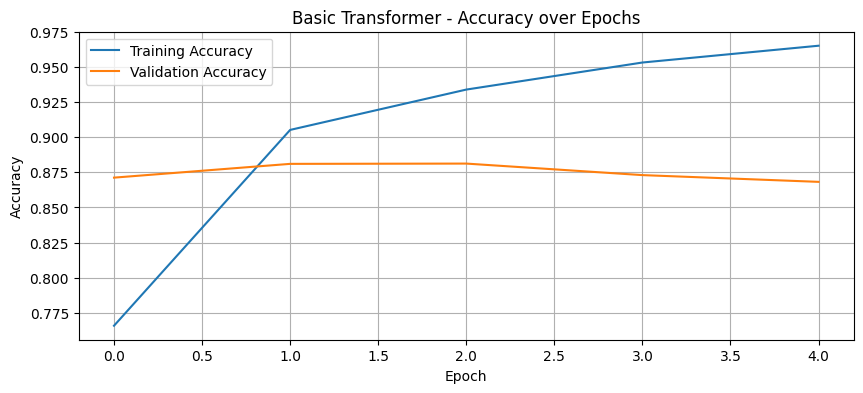

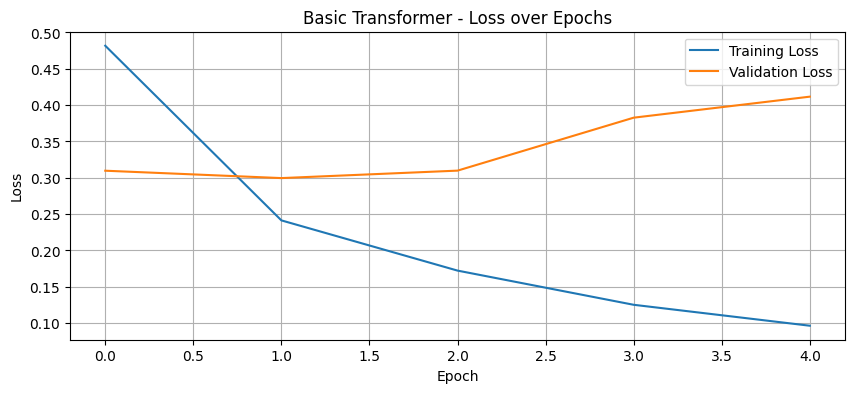

In [8]:
# Display architecture of the basic Transformer model
basic_transformer_model.summary()


import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(history_basic.history['accuracy'], label='Training Accuracy')
plt.plot(history_basic.history['val_accuracy'], label='Validation Accuracy')
plt.title('Basic Transformer - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(history_basic.history['loss'], label='Training Loss')
plt.plot(history_basic.history['val_loss'], label='Validation Loss')
plt.title('Basic Transformer - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Task 7: Build an Advanced Transformer Model

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super().__init__()
        self.pos_encoding = self._get_positional_encoding(maxlen, embed_dim)

    def _get_positional_encoding(self, maxlen, d_model):
        pos = tf.range(maxlen, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]

        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / d_model)
        angle_rads = pos * angle_rates

        # sin on even indices, cos on odd
        sin_part = tf.math.sin(angle_rads[:, 0::2])
        cos_part = tf.math.cos(angle_rads[:, 1::2])

        # Interleave sin and cos
        pos_encoding = tf.concat([sin_part, cos_part], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [17]:
# Parameters
maxlen = 256
vocab_size = 10000
embed_dim = 64
num_heads = 4
ff_dim = 128
dropout_rate = 0.2

# Input layer
inputs = layers.Input(shape=(maxlen,))

# Embedding
embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)

# Add positional encoding
x = PositionalEncoding(maxlen, embed_dim)(embedding)

# Multi-head self-attention
attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
x = layers.Add()([x, attention_output])
x = layers.LayerNormalization()(x)

# Feed-forward network
ffn = layers.Dense(ff_dim, activation='relu')(x)
ffn = layers.Dense(embed_dim)(ffn)
x = layers.Add()([x, ffn])
x = layers.LayerNormalization()(x)

# Global pooling and output
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Model
advanced_transformer_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile
advanced_transformer_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
advanced_transformer_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 256, 64)   │    640,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 256, 64)   │          0 │ embedding_4[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │     66,368 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 64)   │          0 │ positional_encod… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256, 64)   │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 727,425 (2.77 MB)

 Trainable params: 727,425 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

Task 8: Train the Advanced Model

In [ ]:
# Train the advanced Transformer model
history_advanced = advanced_transformer_model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.5091 - loss: 0.7002 - val_accuracy: 0.8184 - val_loss: 0.4404
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.8375 - loss: 0.3796 - val_accuracy: 0.8604 - val_loss: 0.3260
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.9164 - loss: 0.2198

In [ ]:
Task 9: Visualize Model Accuracy and Loss

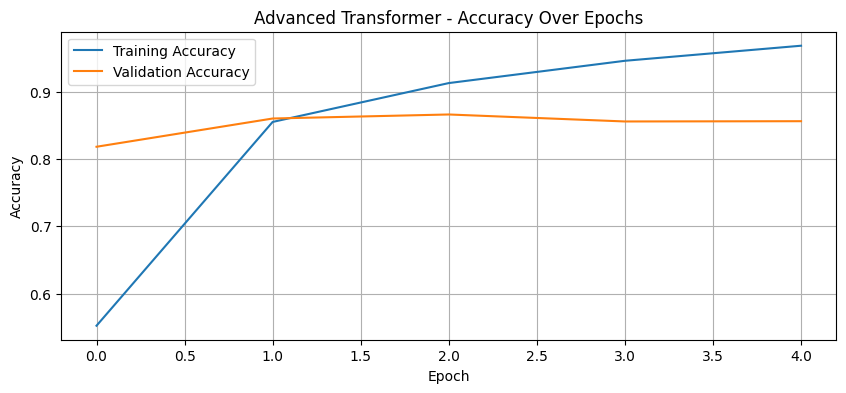

In [19]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history_advanced.history['accuracy'], label='Training Accuracy')
plt.plot(history_advanced.history['val_accuracy'], label='Validation Accuracy')
plt.title('Advanced Transformer - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


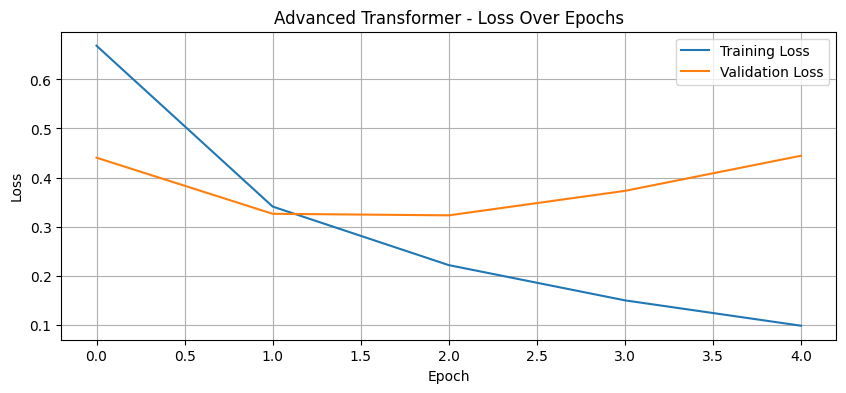

In [20]:
# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history_advanced.history['loss'], label='Training Loss')
plt.plot(history_advanced.history['val_loss'], label='Validation Loss')
plt.title('Advanced Transformer - Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Task 10: Evaluation – Accuracy, Precision, Recall, F1, AUC

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, model_name="Model"):
    print(f"\n📊 Evaluation for: {model_name}")

    # Predict probabilities and binary output
    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype("int32")

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Print results
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Optional: Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Evaluate Basic Transformer
evaluate_model(basic_transformer_model, X_test_padded, y_test, model_name="Basic Transformer")

# Evaluate Advanced Transformer
evaluate_model(advanced_transformer_model, X_test_padded, y_test, model_name="Advanced Transformer")



📊 Evaluation for: Basic Transformer
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step
Accuracy:  0.8384
Precision: 0.8621
Recall:    0.8055
F1 Score:  0.8329
AUC Score: 0.9103

Confusion Matrix:
[[10890  1610]
 [ 2431 10069]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     12500
           1       0.86      0.81      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000


📊 Evaluation for: Advanced Transformer
782/782 ━━━━━━━━━━━━━━━━━━━━ 132s 168ms/step
Accuracy:  0.8316
Precision: 0.8627
Recall:    0.7889
F1 Score:  0.8241
AUC Score: 0.9165

Confusion Matrix:
[[10930  1570]
 [ 2639  9861]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     12500
           1       0.86      0.79      0.82     12500

    accuracy   